In [26]:
import os
import numpy as np
import cv2
import tensorflow as tf

# Créer dossier pour Grad-CAM
os.makedirs('../static/gradcam', exist_ok=True)

# Fonction pour trouver la dernière couche Conv2D
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("Pas de couche Conv2D trouvée.")

# Grad-CAM
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    if len(img_array.shape) == 3:
        img_array = np.expand_dims(img_array, axis=0)

    # Créer un modèle fonctionnel temporaire à partir du Sequential
    inputs = tf.keras.Input(shape=img_array.shape[1:])
    x = inputs
    for layer in model.layers:
        x = layer(x)
        if layer.name == last_conv_layer_name:
            conv_output = x
    output = x
    grad_model = tf.keras.Model(inputs=inputs, outputs=[conv_output, output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = 0
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-8)
    return heatmap

# Overlay
def overlay_heatmap(heatmap, img_bgr, alpha=0.35):
    heatmap = cv2.resize(heatmap, (img_bgr.shape[1], img_bgr.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlaid = cv2.addWeighted(heatmap_color, alpha, img_bgr, 1-alpha, 0)
    return overlaid

# Trouver dernière couche conv
last_conv_layer_name = find_last_conv_layer(model)

# Génération des Grad-CAM
results = []
for i in range(12):
    x, y_true = next(val_data)
    pred = model.predict(x, verbose=0)[0][0]
    y_pred = 1 if pred >= 0.5 else 0

    heatmap = make_gradcam_heatmap(x, model, last_conv_layer_name)

    img_rgb = (x[0]*255).astype(np.uint8)
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    over = overlay_heatmap(heatmap, img_bgr)

    fname = f'../static/gradcam/sample_{i}_true-{idx_to_class[int(y_true[0])]}_pred-{idx_to_class[y_pred]}.jpg'
    cv2.imwrite(fname, over)

    results.append((fname, int(y_true[0]), y_pred, float(pred)))

print("Grad-CAM générés !")


Grad-CAM générés !


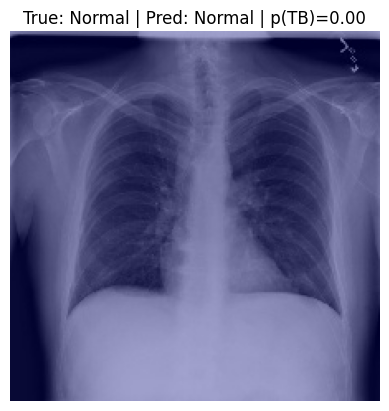

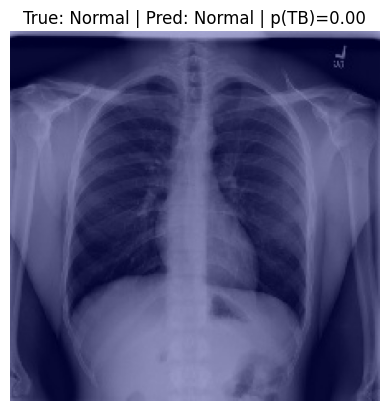

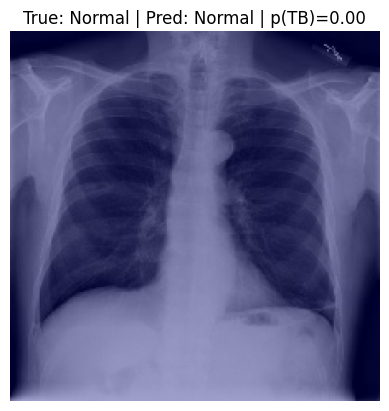

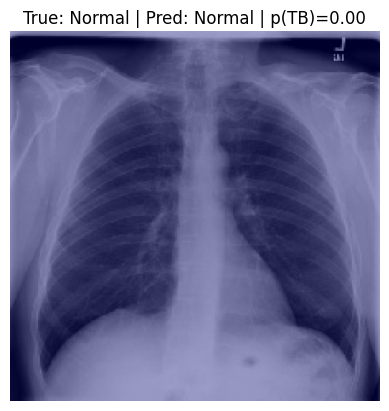

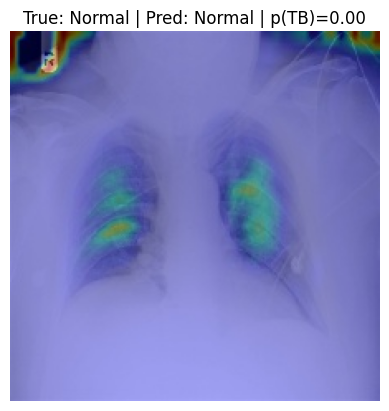

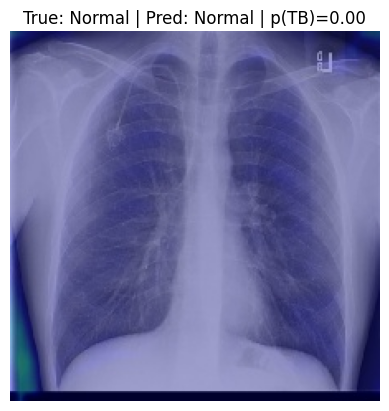

In [27]:
import matplotlib.pyplot as plt
for path, y_true, y_pred, p in results[:6]:
    plt.figure()
    plt.title(f"True: {idx_to_class[int(y_true)]} | Pred: {idx_to_class[y_pred]} | p(TB)={p:.2f}")
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
